# Visualize the fraction of maximum GPs per sample
Plot the relationship between coverage and GP>0.99 

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)
#rcParams['axes.linewidth'] = 0.2  # Set the Default Size of the Boundary for small 2.25in width figures

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/") 
from hapBLOCK.IO.h5_load import get_idx_iid_exact, get_coverage, get_markers_good
#from package.hapBLOCK.IO

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-154.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [38]:
f = h5py.File("./data/hdf5/1240k_v43/ch3.h5", "r") # Load for Sanity Check. See below!
iids = f["samples"][:]
print(f"Loaded {len(iids)} HDF5")

min_cov = 0.1
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v43.4.anno.csv")
print(f"Loaded {len(df)} overall samples from meta")

df_meta["avg_cov_snp"] = pd.to_numeric(df_meta["avg_cov_snp"], errors="coerce")
df_meta= df_meta[(df_meta["age"]>0) & (df_meta["avg_cov_snp"]>min_cov)]
print(f"Loaded {len(df_meta)} Individuals with coverage > {min_cov}")

Loaded 14523 HDF5
Loaded 18171 overall samples from meta
Loaded 10649 Individuals with coverage > 0.1


# Calculate Coverage and GP fraction

In [91]:
#np.sum(f["samples"][:].astype("str")=="SUC001")

In [123]:
%%time

iids = df_meta["iid"].values[:]
covs = np.zeros(len(iids))
gp_frac = np.zeros(len(iids))

print(f"Running {len(iids)} IIDs...")
for i,iid in enumerate(iids):
    try:
        idx = get_idx_iid_exact(f, iid, unique=True)
    except:
        continue # Skip this loop if no single indivdiuals found.
    gp_frac[i] = np.mean(get_markers_good(f, idx, output=False, cutoff=0.99))
    covs[i] = get_coverage(f, idx)

Running 10649 IIDs...
CPU times: user 24min 6s, sys: 38.3 s, total: 24min 44s
Wall time: 26min 38s


In [124]:
df = pd.DataFrame({"iid":iids, "cov":covs, "gp99":gp_frac})
savepath= "./output/tables/cov_vrs_gp99.tsv"
df.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df)} IID data to {savepath}")

Saved 10649 IID data to ./output/tables/cov_vrs_gp99.tsv


### Scatter plot of Coverage vrs GP cutoff

In [136]:
savepath= "./output/tables/cov_vrs_gp99.tsv"
df = pd.read_csv(savepath, sep="\t")

df["color"]="royalblue"
idx_sg = df["iid"].str.contains("SG")
df.loc[idx_sg, "color"]="deeppink"

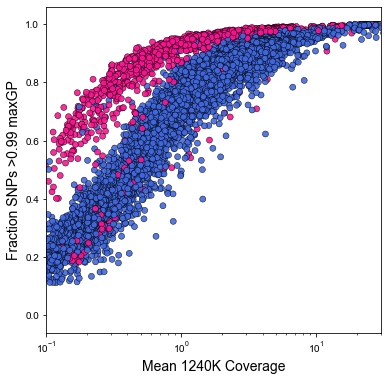

In [137]:
fs=14

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.scatter(df["cov"], df["gp99"], ec="k", alpha=0.9, lw=0.5, c=df["color"])
ax.set_xlabel("Mean 1240K Coverage", fontsize=fs)
ax.set_ylabel("Fraction SNPs >0.99 maxGP", fontsize=fs)
ax.set_xscale("log")
ax.set_xlim([0.1,30])
plt.show()

In [6]:
np.shape(f["calldata/AD"])

(77601, 14523, 4)

In [7]:
np.min(f["calldata/AD"])

-1

In [ ]:
np.max(f["calldata/AD"])